In [ ]:
# Retrieval of satellite images

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Qt5Agg')
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.ion()
import pandas as pd
from datetime import datetime
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

In [ ]:
# !pip install geemap

In [2]:
import ee

In [3]:
import geemap

In [ ]:
# ee.Authenticate()

In [4]:
ee.Initialize()

In [5]:
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [7]:
# region of interest (longitude, latitude)
polygon = [[[151.2957545, -33.7012561],
            [151.297557, -33.7388075],
            [151.312234, -33.7390216],
            [151.311204, -33.701399],
            [151.2957545, -33.7012561]]]
# it's recommended to convert the polygon to the smallest rectangle (sides parallel to coordinate axes)       
polygon = SDS_tools.smallest_rectangle(polygon)
# or load from .geojson
# geojson_polygon = os.path.join(os.getcwd(), 'examples', 'NARRA_polygon.geojson')
# polygon = SDS_tools.polygon_from_geojson(geojson_polygon)
# or load from .kml
# kml_polygon = os.path.join(os.getcwd(), 'examples', 'NARRA_polygon.kml')
# polygon = SDS_tools.polygon_from_kml(kml_polygon)
# date range
dates = ['2017-09-01', '2018-01-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['S2']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
# name of the site
sitename = 'NARRA1'
# directory where the data will be stored
filepath = os.path.join(os.getcwd(), 'data')
# put all the inputs into a dictionnary
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
         'landsat_collection': collection}
# optionally, you can select your Sentinel-2 tile to avoid duplicates from multiple tiles
# inputs['S2tile'] = '56HLH'
# before downloading the images, check how many images are available for your inputs
SDS_download.check_images_available(inputs);

Number of images available between 2017-09-01 and 2018-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 23 images
  Total to download: 23 images


In [8]:
# inputs['include_T2'] = True
metadata = SDS_download.retrieve_images(inputs)

Number of images available between 2017-09-01 and 2018-01-01:
- In Landsat Tier 1 & Sentinel-2 Level-1C:
     S2: 23 images
  Total to download: 23 images

S2: 23 images
100%
Satellite images downloaded from GEE and save in C:\WEBMAP\coastsat\CoastSat\data\NARRA1


In [9]:
settings = {
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
    'output_epsg': 28356,       # epsg code of spatial reference system desired for the output
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery
    's2cloudless_prob': 60,     # probability threshold to identify cloudy pixels in the s2cloudless mask
    
    # add the inputs defined previously
    'inputs': inputs,
}

In [10]:
SDS_preprocess.save_jpg(metadata, settings, use_matplotlib=True)

Saving images as jpg:
S2: 23 images
100%
Satellite images saved as .jpg in C:\WEBMAP\coastsat\CoastSat\data\NARRA1\jpg_files\preprocessed


In [12]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_RGB.mp4'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'preprocessed')
fps = 2 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2700, 1350) to (2704, 1360) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Animation has been generated (using 2 frames per second) and saved at C:\WEBMAP\coastsat\CoastSat\data\NARRA1\NARRA1_animation_RGB.mp4


In [13]:
%matplotlib qt
settings['reference_shoreline'] = SDS_preprocess.get_reference_sl(metadata, settings)
settings['max_dist_ref'] = 100 # max distance (in meters) allowed from the reference shoreline

Reference shoreline has been saved in C:\WEBMAP\coastsat\CoastSat\data\NARRA1


In [14]:
%matplotlib qt
output = SDS_shoreline.extract_shorelines(metadata, settings)

Mapping shorelines:
S2:   100%


In [15]:
output = SDS_tools.remove_duplicates(output) # removes duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_inaccurate_georef(output, 10) # remove inaccurate georeferencing (set threshold to 10 m)

0 duplicates
0 bad georef


In [16]:
from pyproj import CRS
geomtype = 'points' # choose 'points' or 'lines' for the layer geometry
gdf = SDS_tools.output_to_gdf(output, geomtype)
if gdf is None:
    raise Exception("output does not contain any mapped shorelines")
gdf.crs = CRS(settings['output_epsg']) # set layer projection
# save GEOJSON layer to file
gdf.to_file(os.path.join(inputs['filepath'], inputs['sitename'], '%s_output_%s.geojson'%(sitename,geomtype)),
                                driver='GeoJSON', encoding='utf-8')

In [17]:
# create MP4 timelapse animation
fn_animation = os.path.join(inputs['filepath'],inputs['sitename'], '%s_animation_shorelines.mp4'%inputs['sitename'])
fp_images = os.path.join(inputs['filepath'], inputs['sitename'], 'jpg_files', 'detection')
fps = 4 # frames per second in animation
SDS_tools.make_animation_mp4(fp_images, fps, fn_animation)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (2880, 1426) to (2880, 1440) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Animation has been generated (using 4 frames per second) and saved at C:\WEBMAP\coastsat\CoastSat\data\NARRA1\NARRA1_animation_shorelines.mp4


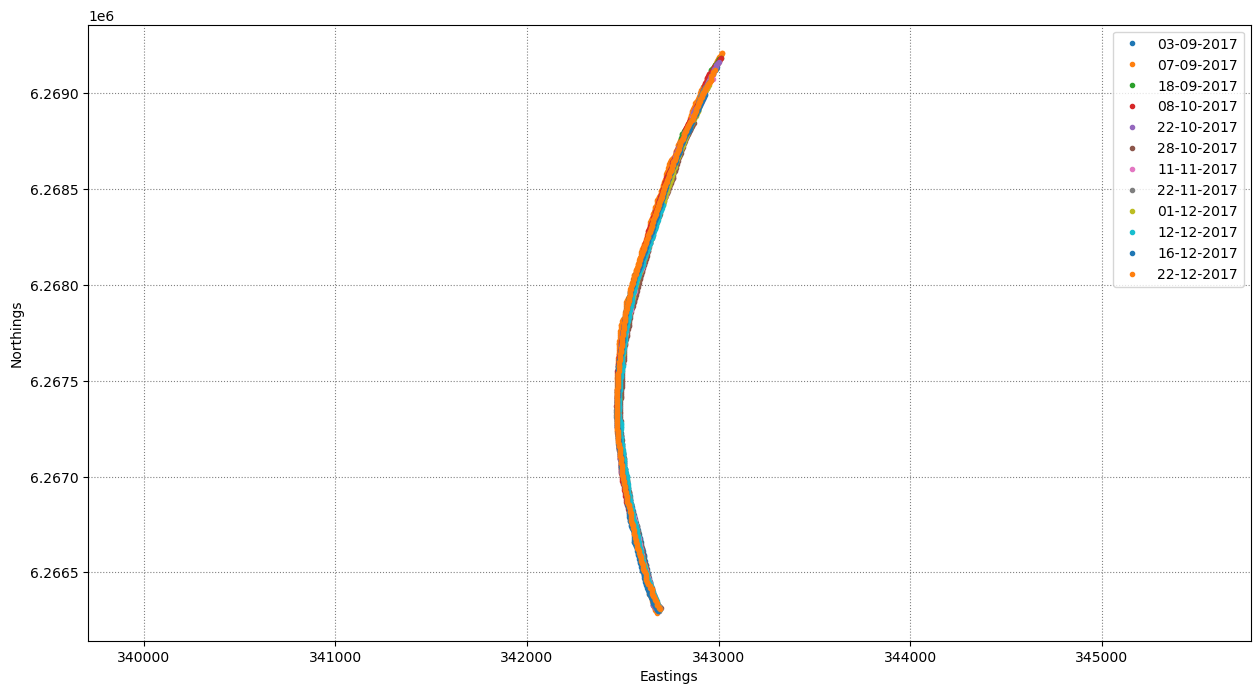

In [18]:
%matplotlib inline
fig = plt.figure(figsize=[15,8])
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
plt.legend();

In [19]:
filepath = os.path.join(inputs['filepath'], sitename)
with open(os.path.join(filepath, sitename + '_output' + '.pkl'), 'rb') as f:
    output = pickle.load(f)
# remove duplicates (images taken on the same date by the same satellite)
output = SDS_tools.remove_duplicates(output)
# remove inaccurate georeferencing (set threshold to 10 m)
output = SDS_tools.remove_inaccurate_georef(output, 10)

0 duplicates
0 bad georef


In [20]:
%matplotlib qt
transects = SDS_transects.draw_transects(output, settings)

Transect locations saved in C:\WEBMAP\coastsat\CoastSat\data\NARRA1


In [21]:
geojson_file = os.path.join(os.getcwd(), 'examples', 'NARRA_transects.geojson')
transects = SDS_tools.transects_from_geojson(geojson_file)

5 transects have been loaded coordinates are in epsg:28356


In [22]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

In [23]:
# along-shore distance over which to consider shoreline points to compute the median intersection
settings_transects = {'along_dist':25}
cross_distance = SDS_transects.compute_intersection(output, transects, settings_transects) 

In [24]:
settings_transects = { # parameters for computing intersections
                      'along_dist':          25,        # along-shore distance to use for computing the intersection
                      'min_points':          3,         # minimum number of shoreline points to calculate an intersection
                      'max_std':             15,        # max std for points around transect
                      'max_range':           30,        # max range for points around transect
                      'min_chainage':        -100,      # largest negative value along transect (landwards of transect origin)
                      'multiple_inter':      'auto',    # mode for removing outliers ('auto', 'nan', 'max')
                      'auto_prc':            0.1,       # percentage of the time that multiple intersects are present to use the max
                     }
cross_distance = SDS_transects.compute_intersection_QC(output, transects, settings_transects) 

In [25]:
fig = plt.figure(figsize=[15,8], tight_layout=True)
gs = gridspec.GridSpec(len(cross_distance),1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, hspace=0.05)
for i,key in enumerate(cross_distance.keys()):
    if np.all(np.isnan(cross_distance[key])):
        continue
    ax = fig.add_subplot(gs[i,0])
    ax.grid(linestyle=':', color='0.5')
    ax.plot(output['dates'], cross_distance[key], '-o', ms=6, mfc='w')
    ax.set_ylabel('distance [m]', fontsize=12)
    ax.text(0.5,0.95, key, bbox=dict(boxstyle="square", ec='k',fc='w'), ha='center',
            va='top', transform=ax.transAxes, fontsize=14)  

In [26]:
# save a .csv file for Excel users
out_dict = dict([])
out_dict['dates'] = output['dates']
for key in transects.keys():
    out_dict[key] = cross_distance[key]
df = pd.DataFrame(out_dict)
fn = os.path.join(settings['inputs']['filepath'],settings['inputs']['sitename'],
                  'transect_time_series.csv')
df.to_csv(fn, sep=',')
print('Time-series of the shoreline change along the transects saved as:\n%s'%fn)

Time-series of the shoreline change along the transects saved as:
C:\WEBMAP\coastsat\CoastSat\data\NARRA1\transect_time_series.csv


In [27]:
# load mapped shorelines from 1984
filename_output = os.path.join(os.getcwd(),'examples','NARRA_output.pkl')
with open(filename_output, 'rb') as f:
    output = pickle.load(f) 

# plot the mapped shorelines
fig = plt.figure(figsize=[15,8], tight_layout=True)
plt.axis('equal')
plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')
plt.title('%d shorelines mapped at Narrabeen from 1984'%len(output['shorelines']))
for i in range(len(output['shorelines'])):
    sl = output['shorelines'][i]
    date = output['dates'][i]
    plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
             va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

# load long time-series (1984-2021)
filepath = os.path.join(os.getcwd(),'examples','NARRA_time_series_tidally_corrected.csv')
df = pd.read_csv(filepath, parse_dates=['dates'])
dates = [_.to_pydatetime() for _ in df['dates']]
cross_distance = dict([])
for key in transects.keys():
    cross_distance[key] = np.array(df[key])

In [28]:
# remove outliers in the time-series (coastal despiking)
settings_outliers = {'max_cross_change':   40,             # maximum cross-shore change observable between consecutive timesteps
                     'otsu_threshold':     [-.5,0],        # min and max intensity threshold use for contouring the shoreline
                     'plot_fig':           True,           # whether to plot the intermediate steps
                    }
cross_distance = SDS_transects.reject_outliers(cross_distance,output,settings_outliers)

NA1  - outliers removed: 2
NA2  - outliers removed: 4
NA3  - outliers removed: 3
NA4  - outliers removed: 1
NA5  - outliers removed: 2
